In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [2]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import noise_estimation_loss
from tools.score_net import score_model
from tools.sampling import ddpm_sampler

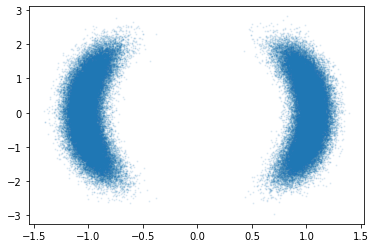

In [3]:
# from sklearn.datasets import make_swiss_roll
# def sample_batch(size, noise=0.5):
#     x, _= make_swiss_roll(size, noise=noise)
#     return x[:, [0, 2]] / 10.0
# data = sample_batch(10**4)

target = nf.distributions.TwoMoons()
data = target.sample(100000)

#normalize data
data_mean = data.mean(0)
data_std = data.std(0)
data = (data - data_mean) / data_std 

def true_likelihood(x):
    x = x * data_std + data_mean
    return target.log_prob(x).cpu().numpy()
# import os
# obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'
# data=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)
# #select data with x<0
# data=data[data[:,0]<0]
# #increase data number by adding small noise
# data_new=data+np.random.normal(0,0.01,data.shape)
# data=np.concatenate([data,data_new],axis=0)

plt.scatter(data[:,0], data[:,1], s=1, alpha=0.1)

In [21]:
ns=noise_scheduler(1e-5,1e-2,100,schedule='sigmoid',var_norm=True)

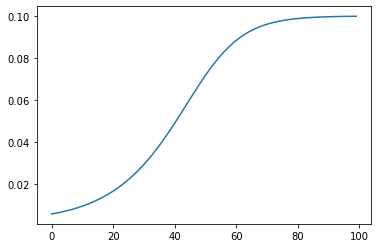

In [22]:
ns.plot_sigmas()

/tmp/ipykernel_2016968/3754102788.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ns.visualize_noise(torch.tensor(data))


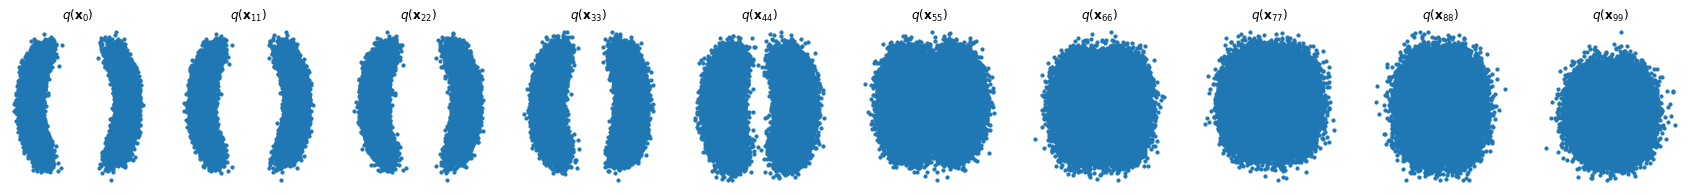

In [23]:
ns.visualize_noise(torch.tensor(data))

In [24]:
model = score_model(num_classes=100,x_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
dataset=torch.tensor(data).float().to(device)
epochs = 1000
batch_size = 1000
for epoch in range(epochs):

    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]

        t = torch.randint(0, ns.n_steps, size=(batch_x.shape[0] // 2 + 1,))
        t = torch.cat([t, ns.n_steps - t - 1], dim=0)[:batch_x.shape[0]].long().to(device)
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x, t,ns)

        optimizer.zero_grad()
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (epoch % 100 == 0):
        print(loss.item())


/tmp/ipykernel_2016968/563047141.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(data).float().to(device)


0.935064971446991
0.650022566318512
0.6397504806518555
0.6528600454330444
0.6632992625236511
0.6585298180580139
0.6613812446594238
0.6562986373901367
0.658607542514801
0.669015645980835


In [26]:
sampler=ddpm_sampler(model,ns.sigmas,ns.n_steps,device=device)

In [27]:
x_seq=sampler.loop_sample(dataset.shape)

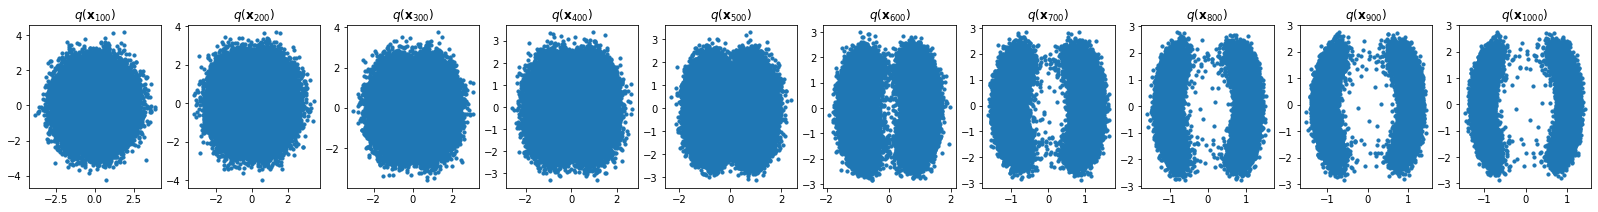

In [30]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1,11):
    cur_x = x_seq[i*9].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

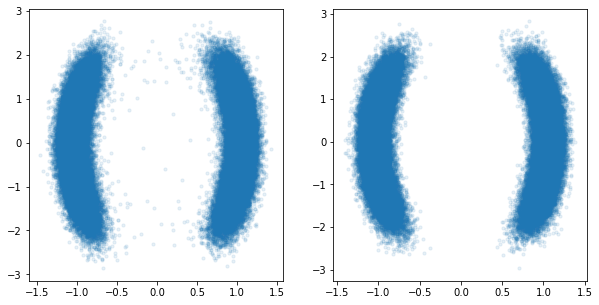

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*x_seq[-1].detach().cpu().T, s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*data.T, s=10, alpha=0.1)


In [13]:
import torch
import math

$$
\begin{aligned}
\log p(x)\geq \underbrace{\mathbb{E}_{q(\boldsymbol{x}_1|\boldsymbol{x}_0)}\left[\log p_{\boldsymbol{\theta}}(\boldsymbol{x}_0|\boldsymbol{x}_1)\right]}_{\text{reconstruction term}}&-\underbrace{D_{\mathrm{KL}}(q(\boldsymbol{x}_T|\boldsymbol{x}_0)\parallel p(\boldsymbol{x}_T))}_{\text{prior matching term}}\\&-\sum_{t=2}\underbrace{\mathbb{E}_{q(\boldsymbol{x}_t|\boldsymbol{x}_0)}\left[D_{\mathrm{KL}}(q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t,\boldsymbol{x}_0)\parallel p_{\boldsymbol{\theta}}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t))\right]}_{\text{denoising matching term}}
\end{aligned}
$$

In [31]:
n_steps = ns.n_steps
alphas = ns.alphas
alphas_prod = ns.alphas_prod
one_minus_alphas_bar_sqrt = ns.one_minus_alphas_bar_sqrt
betas = 1-alphas

alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)

In [32]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def p_mean_variance(model, x, t):
    # t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))

    var = extract(betas, t, x)

    log_var = torch.log(var.clamp(min=1e-10))

    return mean,log_var


posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    # print(coef_1, coef_2, x_0, x_t)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [57]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + torch.sum((mean1 - mean2) ** 2,dim=-1,keepdim=True) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

def compute_loss(true_mean, true_var, model_mean, model_var):
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * n_steps + H_start - H_end + H_prior
    return negL_bound#L_diff_bits_avg

def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]
    t = torch.ones(batch_size).long()*50
    # Perform diffusion for step t
    x_t = ns.forward_sample(x_0, t)[0]
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, true_var)

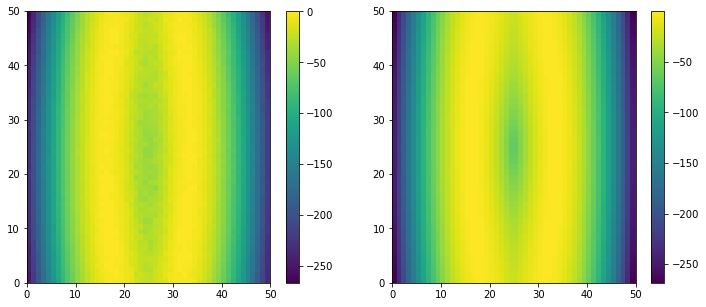

In [65]:
model.to('cpu')
xx = np.stack(np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-2, 2.0, 50)), axis=-1).reshape(-1, 2)
x_0 = torch.tensor(xx).float()#.to(device)
estimate_logL=0
for _ in range(100):
    estimate_logL = estimate_logL -loss_likelihood_bound(model,x_0)
estimate_logL_VLB=estimate_logL/100
# estimate_logL=estimate_logL.clamp(max=0)

true_logp=true_likelihood(x_0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor((estimate_logL_VLB.reshape(50, 50).detach().cpu().numpy()))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolor((true_logp.reshape(50, 50)))
plt.colorbar()

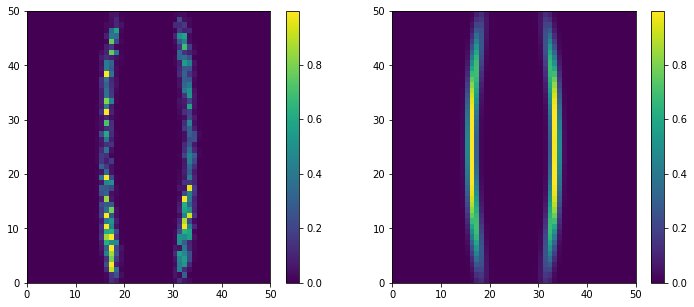

In [66]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor(np.exp(estimate_logL_VLB.reshape(50, 50).detach().cpu().numpy()),vmax=np.exp(np.max(true_logp)))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolor(np.exp(true_logp.reshape(50, 50)))
plt.colorbar()

In [69]:

import normflows as nf
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tools.sde_lib import VESDE
from tools.loss import sde_score_matching_loss
from tools.sde_sampler import PC_sampler
from tools.sde_sampler import ode_sampler
from tools.likelihood import ode_likelihood
device='cuda'

In [70]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class LinearCond(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim, embed_dim):
    super().__init__()
    self.x_lin = nn.Linear(input_dim, output_dim)
    self.embed_lim= nn.Linear(embed_dim, output_dim)
  def forward(self, x,embed):
    return self.x_lin(x) + self.embed_lim(embed)



class ScoreNet(nn.Module):
  """A score network that estimates the score of a trajectory."""
  def __init__(self, input_dim, embed_dim):

    super().__init__()
    self.embed = nn.Sequential(
      GaussianFourierProjection(embed_dim),
      nn.Linear(embed_dim, 128),
    )

    self.linear1 = LinearCond(input_dim,128,128)
    self.linear2 = LinearCond(128,128,128)
    self.linear3 = LinearCond(128,128,128)
    self.output = nn.Linear(128,input_dim)

  def forward(self, x, t):
    emb = F.softplus(self.embed(t))

    x = self.linear1(x,emb)
    x = F.softplus(x)
    x = self.linear2(x,emb)
    x = F.softplus(x)
    x = self.linear3(x,emb)
    x = F.softplus(x)
    x = self.output(x)
    return x

In [75]:
test_sde=VESDE(sigma_min=0.1,sigma_max=1,N=100)

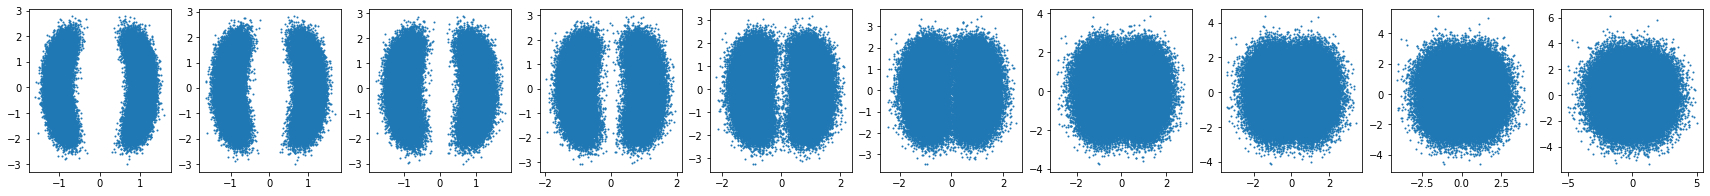

In [76]:
stds = test_sde.discrete_sigmas[np.linspace(0,99,10).astype(int)]
plt.figure(figsize=(30,3))
z = torch.randn_like(data)
for i,std in enumerate(stds):
    perturbed_x = data + z * std
    plt.subplot(1,10,i+1)
    plt.scatter(*perturbed_x.T,s=1)

In [78]:
score_model = ScoreNet(input_dim=2, embed_dim=4)
score_model = score_model.to(device)

n_epochs =   1000
## size of a mini-batch
batch_size =  1000

lr=1e-3

optimizer = Adam(score_model.parameters(), lr=lr)
# tqdm_epoch = tqdm.notebook.trange(n_epochs)

dataset = torch.tensor(data, dtype=torch.float32).to(device)

for epoch in range(n_epochs):
  num_items = 0
  permutation = torch.randperm(dataset.size()[0])
  
  for i in range(0, dataset.size()[0], batch_size):
    indices = permutation[i:i+batch_size]
    batch_x = dataset[indices] 

    loss = sde_score_matching_loss(score_model, batch_x, test_sde)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    num_items += batch_x.shape[0]
  if epoch%100==0:
    print(loss.item())


/tmp/ipykernel_2016968/1147834286.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float32).to(device)


1.6990656852722168
1.3646069765090942
1.236209750175476
1.198758602142334
1.2190190553665161
1.175447940826416
1.1416033506393433
1.1894910335540771
1.1455578804016113
1.1324052810668945


(-3.0, 3.0)

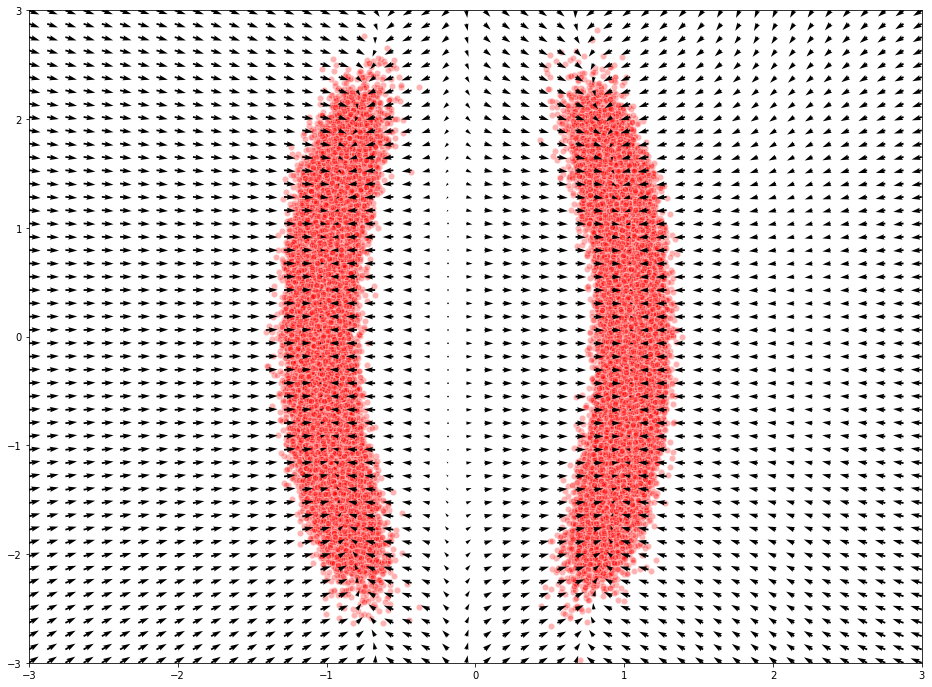

In [79]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
times = torch.ones(xx.shape[0]).to(device)*1e-5
scores = score_model(torch.tensor(xx).float().to(device), times).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [80]:
pc_sampler=PC_sampler(test_sde,score_model,n_correct_steps=1000,snr=1e-4)
test_samles=pc_sampler.sample(10000)

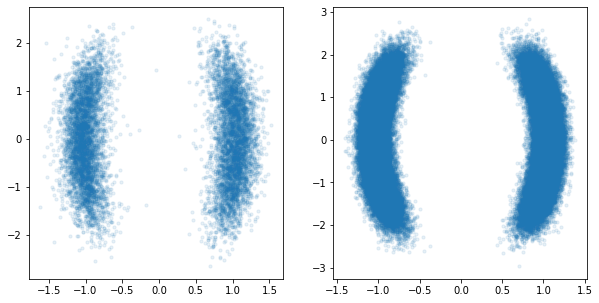

In [81]:

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(*test_samles.cpu().numpy().T , s=10, alpha=0.1)
plt.subplot(122)
plt.scatter(*data.T , s=10, alpha=0.1)

In [82]:
o_sampler=ode_sampler(test_sde,score_model)
test_osamples=o_sampler.sample(10000)[0]

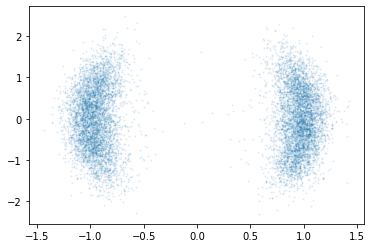

In [83]:
plt.scatter(*test_osamples.cpu().T, s=1, alpha=0.1)

In [84]:
o_likelihood= ode_likelihood(test_sde,score_model)

In [88]:
x0 = np.stack(np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-2, 2.0, 50)), axis=-1).reshape(-1, 2)
xx = torch.tensor(x0).float().to(device)
logL_ode = o_likelihood.likelihood_eval(xx)[1]
true_logp=true_likelihood(xx.cpu())

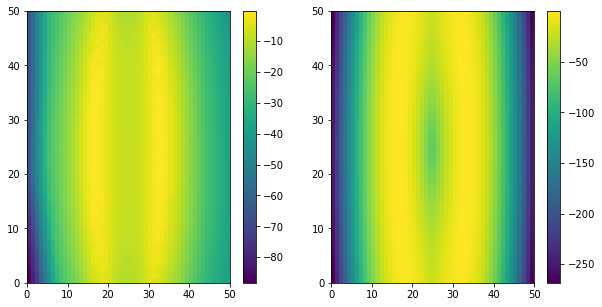

In [89]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pcolor((logL_ode.cpu().numpy().reshape(50,50)))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolor((true_logp.reshape(50,50)))
plt.colorbar()

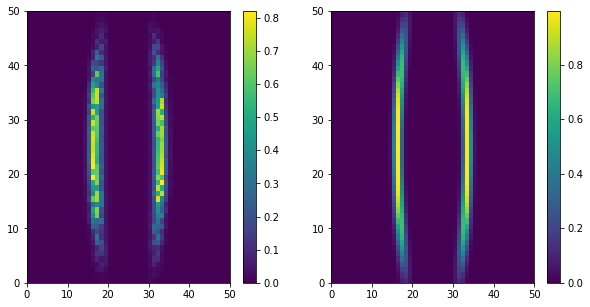

In [90]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pcolor(np.exp(logL_ode.cpu().numpy().reshape(50,50)))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolor(np.exp(true_logp.reshape(50,50)))
plt.colorbar()

Line Integration

In [91]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import anneal_dsm_score_estimation
from tools.score_net import score_model
from tools.sampling import annealed_langevin_dynamic_sampler

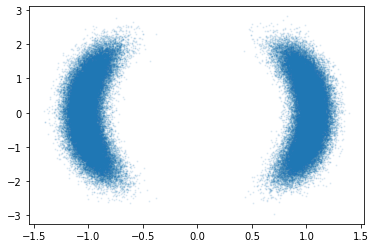

In [92]:
plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

In [93]:

ns=noise_scheduler(1e-3,0.2,100,schedule='sigmoid',var_norm=False)

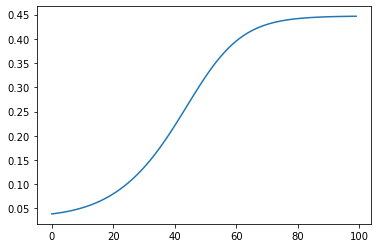

In [94]:
ns.plot_sigmas()

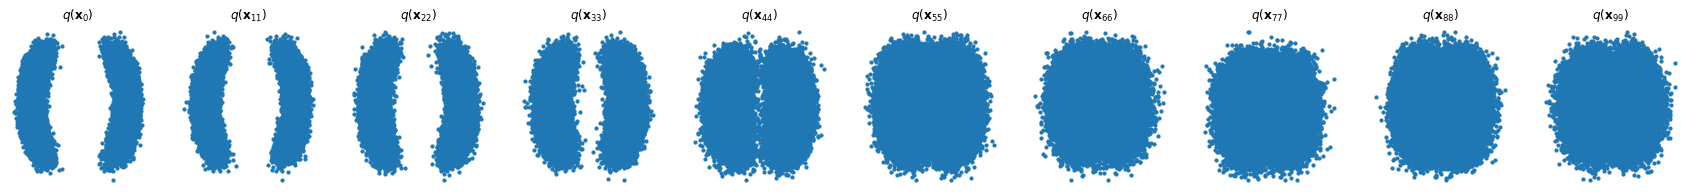

In [95]:
ns.visualize_noise(data)

In [96]:
# Our approximation model
model = score_model(ns.n_steps,2).to(device)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [97]:
epochs=1000
batch_size=1000
dataset = torch.tensor(data, dtype=torch.float32).to(device)
for epoch in range(epochs):
    # for batch in dataloader:

        # batch = batch[0].to(device)
    permutation = torch.randperm(dataset.size()[0])

    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch = dataset[indices]
        labels = torch.randint(0, ns.n_steps, (batch.shape[0],)).to(device)

        loss = anneal_dsm_score_estimation(model, batch, labels, ns)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if ((epoch % 100) == 0):
        print(loss.item())



/tmp/ipykernel_2016968/1829299542.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float32).to(device)


0.9117688536643982
0.5848914980888367
0.6379907727241516
0.6584295034408569
0.6127764582633972
0.5886794924736023
0.5766487717628479
0.6298125386238098
0.6676896810531616
0.6095240712165833


(-3.0, 3.0)

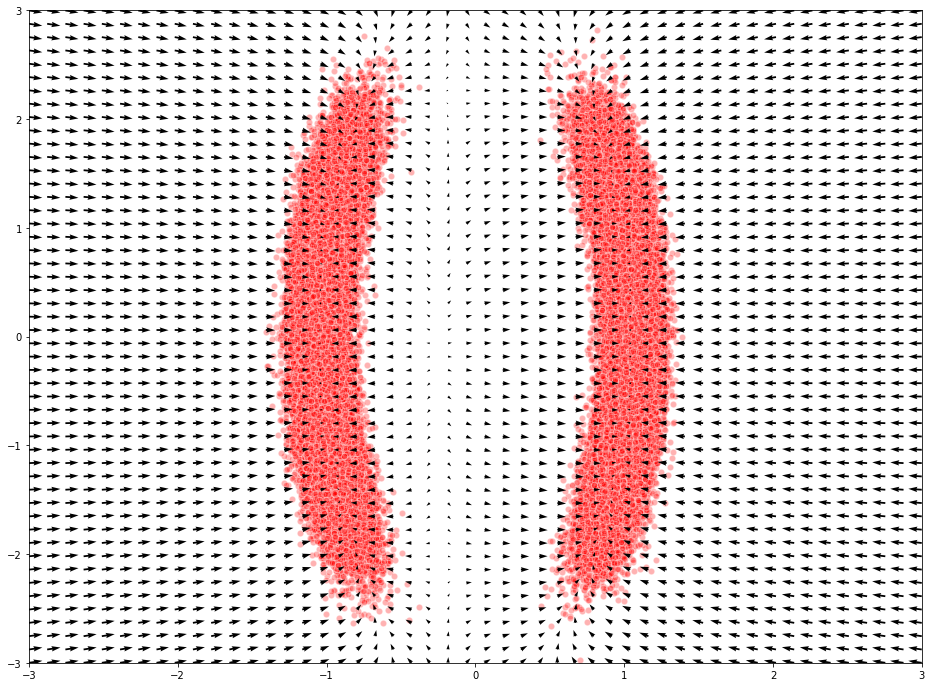

In [98]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long().to(device)*0
scores = model(torch.tensor(xx).float().to(device), labels).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [99]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=1000 , 
                                            score_fn=model, 
                                            device=device, 
                                            eps = 1e-5)

In [100]:
init_point=torch.randn(10000,2).to(device)*3.5-1.5
dynamic=sampler.sample(init_point)

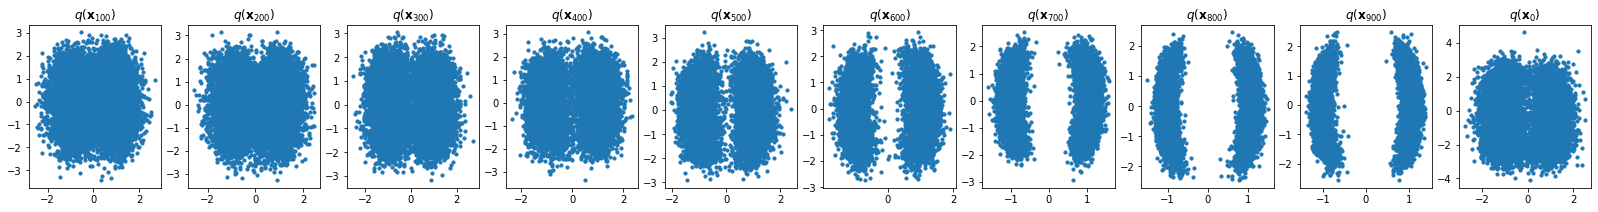

In [101]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    cur_x = dynamic[i*10].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

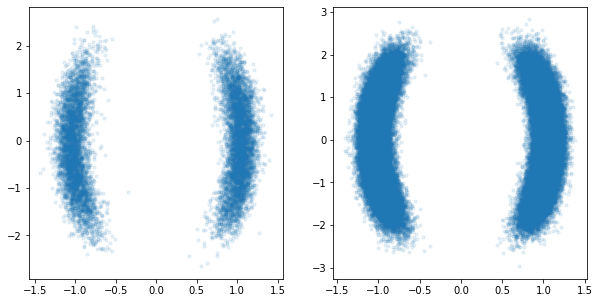

In [102]:

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(*dynamic[-1].cpu().numpy().T , s=10, alpha=0.1)
plt.subplot(122)
plt.scatter(*data.T , s=10, alpha=0.1)

In [103]:
model.to('cpu');

In [104]:
import numpy as np
from scipy.integrate import quad
import torch


# Define the vector field function F(x, y)
def vector_field(x, y):
    input = torch.tensor([[x, y]]).float()
    labels = torch.ones(1).long()*0
    with torch.no_grad():
        score = model(input, labels).detach().cpu().numpy()[0]
    return score

def line_integral(initial_point, end_point, vector_field):
    # Define the parametric equation of the curve r(t) = (x(t), y(t))
    # For example, you can use a simple linear path:
    def x_t(t):
        return t*(end_point[0]-initial_point[0])+initial_point[0]

    def y_t(t):
        return t**2*(end_point[1]-initial_point[1])+initial_point[1]

    # Define the curve vector r(t)
    def r_t(t):
        return np.array([x_t(t), y_t(t)])

    # Numerical approximation of the derivative
    dt = 1e-6
    dr_dt = lambda t: (r_t(t + dt) - r_t(t - dt)) / (2 * dt)

    # Define the integrand for the line integral
    def integrand(t):
        F_at_curve = vector_field(*r_t(t))
        dot_product = np.dot(F_at_curve, dr_dt(t))
        return dot_product

    result, _ = quad(integrand, 0, 1)
    return result

In [109]:
x0 = np.stack(np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-2, 2.0, 50)), axis=-1).reshape(-1, 2)
xx = torch.tensor(x0).float().to(device)

initial_point = np.array([0, 0])
# end_point = np.array([2, 4])
logL_integral=np.zeros(x0.shape[0])
for idx,point in enumerate(x0):
    logL_integral[idx] = line_integral(initial_point, point, vector_field)

true_logp=true_likelihood(xx.cpu())

/tmp/ipykernel_2016968/3098538335.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(integrand, 0, 1)


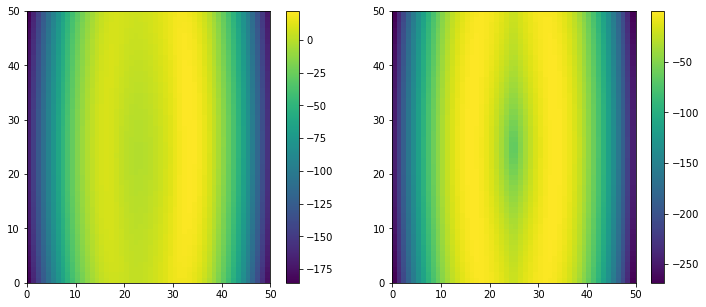

In [112]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor((logL_integral.reshape(50, 50)))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolor((true_logp.reshape(50, 50)))
plt.colorbar()

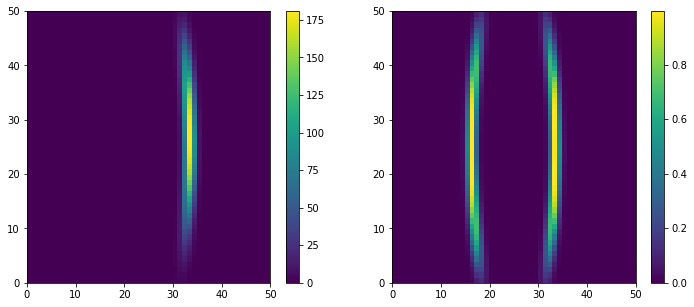

In [113]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor(np.exp(logL_integral.reshape(50, 50)-17))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolor(np.exp(true_logp.reshape(50, 50)))
plt.colorbar()

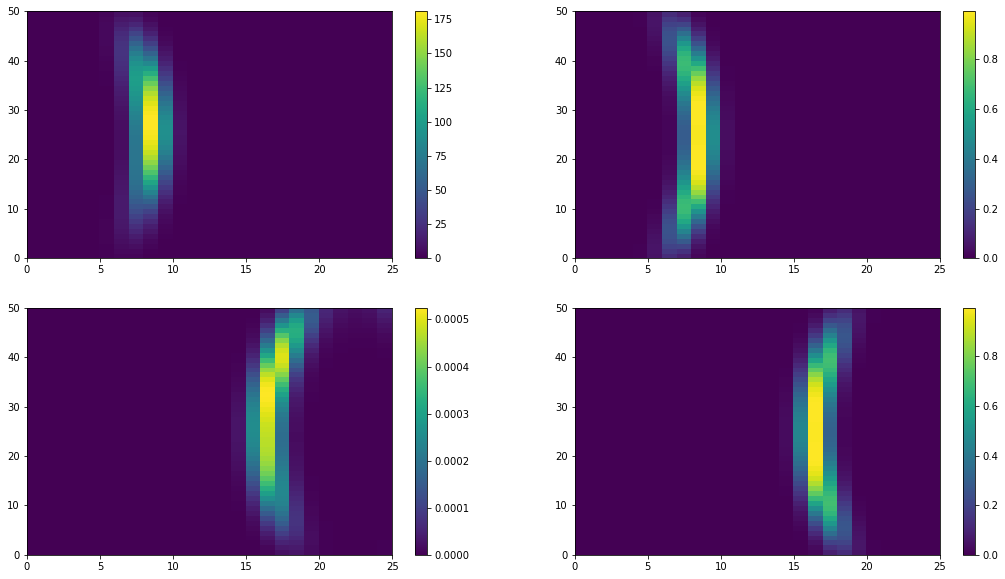

In [116]:
# plt.pcolor(np.exp(estimate_logL[:,0].reshape(50, 50)-17))

plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.pcolor(np.exp(logL_integral.reshape(50, 50)-17)[:,25:])
plt.colorbar()
plt.subplot(2, 2, 2)
plt.pcolor(np.exp(true_logp.reshape(50, 50))[:,25:])
plt.colorbar()

plt.subplot(2, 2, 3)
plt.pcolor(np.exp(logL_integral.reshape(50, 50)-17)[:,:25])
plt.colorbar()
plt.subplot(2, 2, 4)
plt.pcolor(np.exp(true_logp.reshape(50, 50))[:,:25])
plt.colorbar()

In [117]:
x0 = np.stack(np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-2, 2.0, 50)), axis=-1).reshape(-1, 2)
xx = torch.tensor(x0).float().to(device)

initial_point = np.array([-1, 0])
# end_point = np.array([2, 4])
logL_integral=np.zeros(x0.shape[0])
for idx,point in enumerate(x0):
    logL_integral[idx] = line_integral(initial_point, point, vector_field)

true_logp=true_likelihood(xx.cpu())

/tmp/ipykernel_2016968/3098538335.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(integrand, 0, 1)


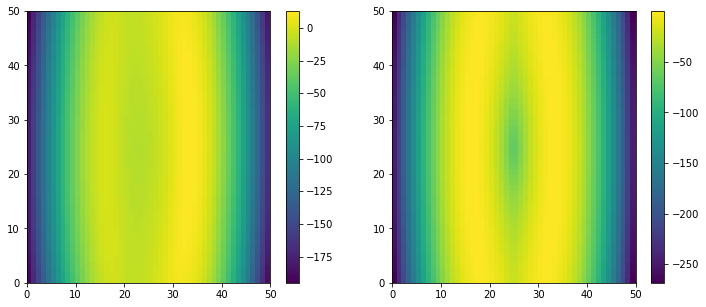

In [118]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor((logL_integral.reshape(50, 50)))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolor((true_logp.reshape(50, 50)))
plt.colorbar()

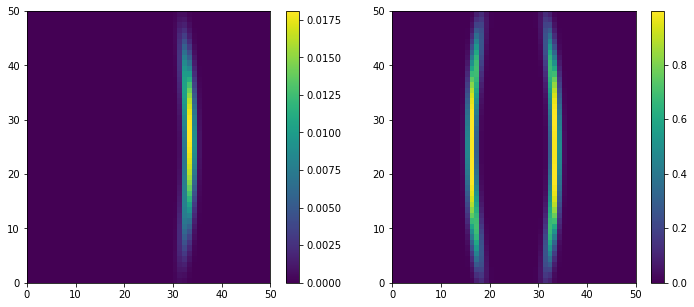

In [119]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolor(np.exp(logL_integral.reshape(50, 50)-17))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolor(np.exp(true_logp.reshape(50, 50)))
plt.colorbar()

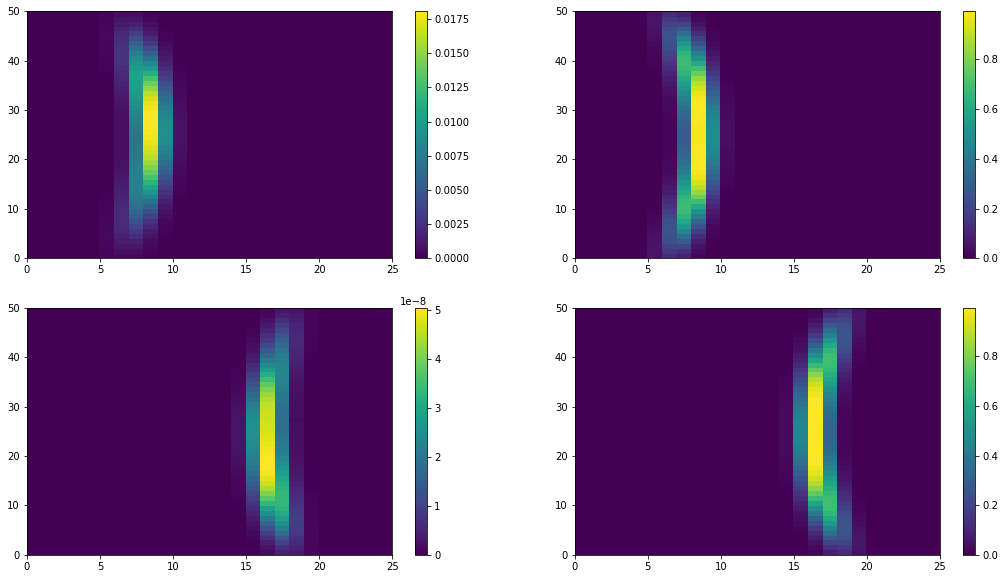

In [120]:
# plt.pcolor(np.exp(estimate_logL[:,0].reshape(50, 50)-17))

plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.pcolor(np.exp(logL_integral.reshape(50, 50)-17)[:,25:])
plt.colorbar()
plt.subplot(2, 2, 2)
plt.pcolor(np.exp(true_logp.reshape(50, 50))[:,25:])
plt.colorbar()

plt.subplot(2, 2, 3)
plt.pcolor(np.exp(logL_integral.reshape(50, 50)-17)[:,:25])
plt.colorbar()
plt.subplot(2, 2, 4)
plt.pcolor(np.exp(true_logp.reshape(50, 50))[:,:25])
plt.colorbar()

Compare all methods

Text(0.5, 0.98, 'logP')

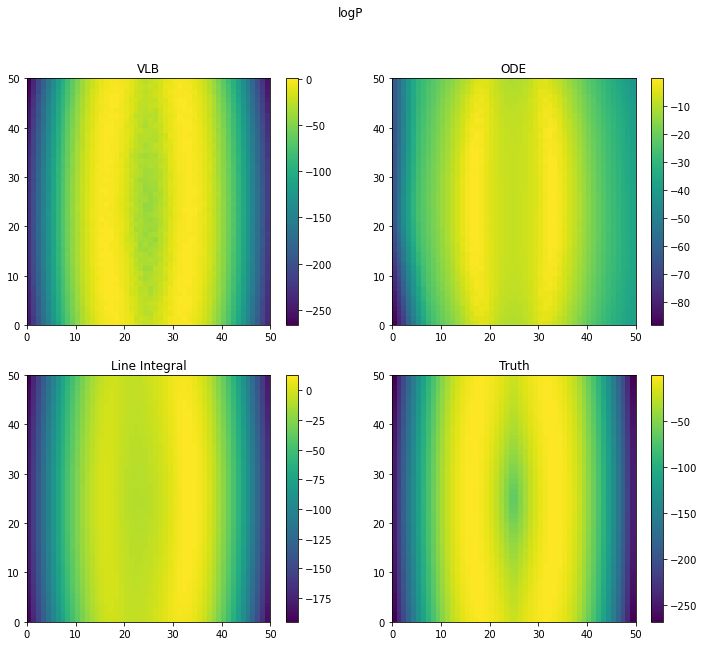

In [122]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.pcolor((estimate_logL_VLB.reshape(50, 50).detach().cpu().numpy()))
plt.colorbar()
plt.title("VLB")

plt.subplot(2, 2, 2)
plt.pcolor((logL_ode.cpu().numpy().reshape(50,50)))
plt.colorbar()
plt.title("ODE")

plt.subplot(2, 2, 3)
plt.pcolor((logL_integral.reshape(50, 50)))
plt.colorbar()
plt.title("Line Integral")

plt.subplot(2,2,4)
plt.pcolor((true_logp.reshape(50, 50)))
plt.colorbar()
plt.title("Truth")

plt.suptitle('logP')


Text(0.5, 0.98, 'P')

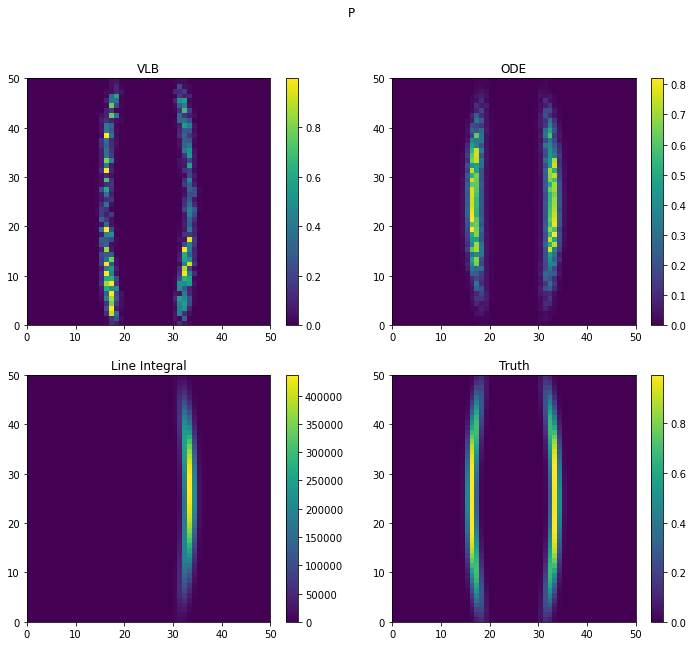

In [125]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.pcolor(np.exp(estimate_logL_VLB.reshape(50, 50).detach().cpu().numpy()),vmax=np.exp(np.max(true_logp)))
plt.colorbar()
plt.title("VLB")

plt.subplot(2, 2, 2)
plt.pcolor(np.exp(logL_ode.cpu().numpy().reshape(50,50)))
plt.colorbar()
plt.title("ODE")

plt.subplot(2, 2, 3)
plt.pcolor(np.exp(logL_integral.reshape(50, 50)-np.max(logL_integral)))
plt.colorbar()
plt.title("Line Integral")

plt.subplot(2,2,4)
plt.pcolor(np.exp(true_logp.reshape(50, 50)))
plt.colorbar()
plt.title("Truth")

plt.suptitle('P')


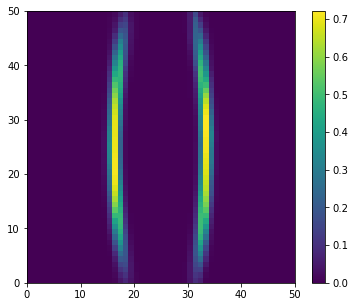

In [6]:
import numpy as np 
from matplotlib import pyplot as plt

prob=np.load('nf_twomoon_prob.npy')

plt.figure(figsize=(6,5))
plt.pcolor(prob)
plt.colorbar()